In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Mounted my google drive to google colab

In [2]:
!unzip /content/drive/MyDrive/data.zip

Archive:  /content/drive/MyDrive/data.zip
   creating: data/
   creating: data/BrainTumor/
  inflating: data/BrainTumor/Cancer (1).jpg  
  inflating: data/BrainTumor/Cancer (10).jpg  
  inflating: data/BrainTumor/Cancer (10).tif  
  inflating: data/BrainTumor/Cancer (1000).jpg  
  inflating: data/BrainTumor/Cancer (1001).jpg  
  inflating: data/BrainTumor/Cancer (1003).jpg  
  inflating: data/BrainTumor/Cancer (1007).jpg  
  inflating: data/BrainTumor/Cancer (1008).jpg  
  inflating: data/BrainTumor/Cancer (101).jpg  
  inflating: data/BrainTumor/Cancer (1013).JPG  
  inflating: data/BrainTumor/Cancer (1017).jpg  
  inflating: data/BrainTumor/Cancer (1018).jpg  
  inflating: data/BrainTumor/Cancer (102).jpg  
  inflating: data/BrainTumor/Cancer (1021).jpg  
  inflating: data/BrainTumor/Cancer (1025).JPG  
  inflating: data/BrainTumor/Cancer (1027).JPG  
  inflating: data/BrainTumor/Cancer (103).jpg  
  inflating: data/BrainTumor/Cancer (1033).jpg  
  inflating: data/BrainTumor/Cancer (

Unzipping the data Folder

In [3]:
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms


class CustomImageDataset(Dataset):
    def read_data_set(self):

        all_img_files = []
        all_labels = []

        class_names = os.walk(self.data_set_path).__next__()[1]

        for index, class_name in enumerate(class_names):
            label = index
            img_dir = os.path.join(self.data_set_path, class_name)
            img_files = os.walk(img_dir).__next__()[2]

            for img_file in img_files:
                img_file = os.path.join(img_dir, img_file)
                img = Image.open(img_file)
                if img is not None:
                    all_img_files.append(img_file)
                    all_labels.append(label)

        return all_img_files, all_labels, len(all_img_files), len(class_names)

    def __init__(self, data_set_path, transforms=None):
        self.data_set_path = data_set_path
        self.image_files_path, self.labels, self.length, self.num_classes = self.read_data_set()
        self.transforms = transforms

    def __getitem__(self, index):
        image = Image.open(self.image_files_path[index])
        image = image.convert("RGB")

        if self.transforms is not None:
            image = self.transforms(image)

        return image, self.labels[index]

    def __len__(self):
        return self.length

Our data is stored in data folder containing 2 sub folders for each class containing the corresponding images respectively

In [4]:
transforms_train = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.RandomRotation(10.),
                                       transforms.ToTensor()])

train_data_set = CustomImageDataset(data_set_path="/content/data", transforms=transforms_train)
train_loader = DataLoader(train_data_set, batch_size=12, shuffle=True)

Preparing the train loader

In [5]:
batch=next(iter(train_loader))

In [6]:
len(batch)

2

In [7]:
type(batch)

list

In [8]:
images = batch[0]
labels = batch[1]

In [9]:
images.shape

torch.Size([12, 3, 128, 128])

As we can see , we have RGB image of size 128*128 with batch size of 16

In [10]:
labels.shape

torch.Size([12])

For 16 images ,we  have 16 corresponding labels

In [11]:
labels

tensor([1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0])

labels : tensor([1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0])


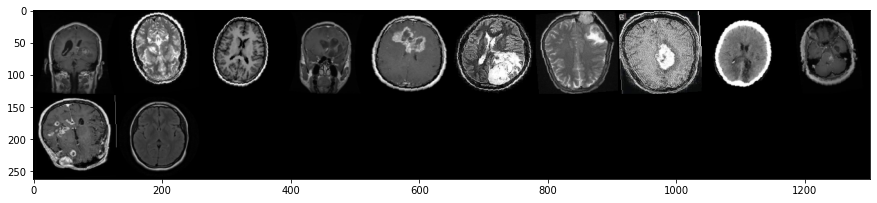

In [12]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
grid = torchvision.utils.make_grid(images,nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)))
print(f"labels : {labels}")

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [14]:
class CustomNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 16, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(16,32, kernel_size = 2, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(32, 64, kernel_size = 2, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(64 ,128, kernel_size = 2, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(139392,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,2)
        )
    
    def forward(self, xb):
        return self.network(xb)


In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:
device

device(type='cuda', index=0)

As we can see , the device is in cuda now

In [17]:
def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

This function gives the number of correct prediction

In [18]:
from itertools import product
from torch.utils.tensorboard import SummaryWriter

In [19]:
parameters = dict(
    lr = [0.1,0.01],
    batch_size = [10,100]
)

In [20]:
param_values = [v for v in parameters.values()]
param_values

[[0.1, 0.01], [10, 100]]

In [21]:
for lr,batch_size in product(*param_values):
  network2 = CustomNetwork()
  network2.cuda()
  train_loader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True)
  optimizer = torch.optim.Adam(network2.parameters(), lr=lr)
  images,labels = next(iter(train_loader))
  images=images.to(device)
  labels=labels.to(device)
  grid = torchvision.utils.make_grid(images)
  comment = f'batch_size = {batch_size} lr={lr}'
  tb = SummaryWriter(comment=comment)
  tb.add_image('images',grid)
  tb.add_graph(network2,images)

  for epoch in range(3):

    total_loss = 0
    total_correct = 0
    for i, item in enumerate(train_loader):
        images = item[0].to(device)
        labels = item[1].to(device)

        preds = network2(images)
        loss = F.cross_entropy(preds,labels)
        total_loss += loss.item() * batch_size

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_correct += get_num_correct(preds,labels)
        avg_loss = total_loss / len(train_loader)

    tb.add_scalar('Loss',total_loss,epoch)
    tb.add_scalar('Number Correct',total_correct,epoch)
    tb.add_scalar('Accuracy',total_correct/len(train_data_set),epoch)

    for name,weight in network2.named_parameters():
      tb.add_histogram(name,weight,epoch)
      tb.add_histogram(f'{name}.grad',weight.grad,epoch)

    print("epoch:",epoch,"total_correct:",total_correct,"loss:",avg_loss)

  tb.close()

epoch: 0 total_correct: 2420 loss: 278425.6000825789
epoch: 1 total_correct: 2477 loss: 6.940229839604834
epoch: 2 total_correct: 2399 loss: 6.973640351191811
epoch: 0 total_correct: 2294 loss: 41631983.88136806
epoch: 1 total_correct: 2251 loss: 3469.9215396590853
epoch: 2 total_correct: 2264 loss: 833.1499627102976
epoch: 0 total_correct: 2514 loss: 10.422731166300567
epoch: 1 total_correct: 2513 loss: 6.898086396248444
epoch: 2 total_correct: 2511 loss: 6.893972720788873
epoch: 0 total_correct: 2658 loss: 901.4184528070947
epoch: 1 total_correct: 3467 loss: 48.81688920052155
epoch: 2 total_correct: 3622 loss: 42.49706624642663
